In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
from bg_atlasapi import BrainGlobeAtlas
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from final_processing import final_processing_functions as fpf
import seaborn as sb
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import scipy
from scipy.stats import pearsonr
from matplotlib.patches import Rectangle
from matplotlib import patches as patches
from preprocessing_sequencing import preprocess_sequences as ps
%matplotlib inline

In [2]:
clustering = pd.read_pickle('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/clustering.pkl')

In [328]:
#first let's group centroids of ROIs in visual cortex into bins
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

bin_size_max = 5
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
#first get AP positions of centroids for every ROI in visual cortex

#then make bins to group based on certain range of AP position

#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d']

mouse_dict_AP_source = {}

for mouse in mice:
    AP_position_dict = {}
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    all_VIS_ROI = np.unique(ROI_3D *  VIS_mask * contra_mask)
    all_VIS_ROI = [sample for sample in all_VIS_ROI if sample != 0]
    for sample in all_VIS_ROI:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = centroid[0]-AP_midpoint_VIS
    mouse_dict_AP_source[mouse]=AP_position_dict
#now lets make equal size bins around min and max AP positions in visual cortex
bin_size = (max_y - min_y)/bin_size_max
bin_ranges = {}
min_val = AP_midpoint_VIS - max_y
for bin in range(0, int(bin_size_max), 1):
    bin_ranges[bin] = [min_val, min_val+bin_size]
    min_val = min_val+bin_size
binned_lcm = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    binned_lcm_indiv_mouse={}
    AP_position_dict = mouse_dict_AP_source[mouse]
    for key in bin_ranges.keys():
        bin_list=[]
        for AP_key in AP_position_dict.keys():
            if bin_ranges[key][0] <= AP_position_dict[AP_key] < bin_ranges[key][1]:
                if AP_key in barcodes.columns:
                    bin_list.append(AP_key)
        binned_lcm_indiv_mouse[key] = bin_list
    
    binned_lcm[mouse] = binned_lcm_indiv_mouse

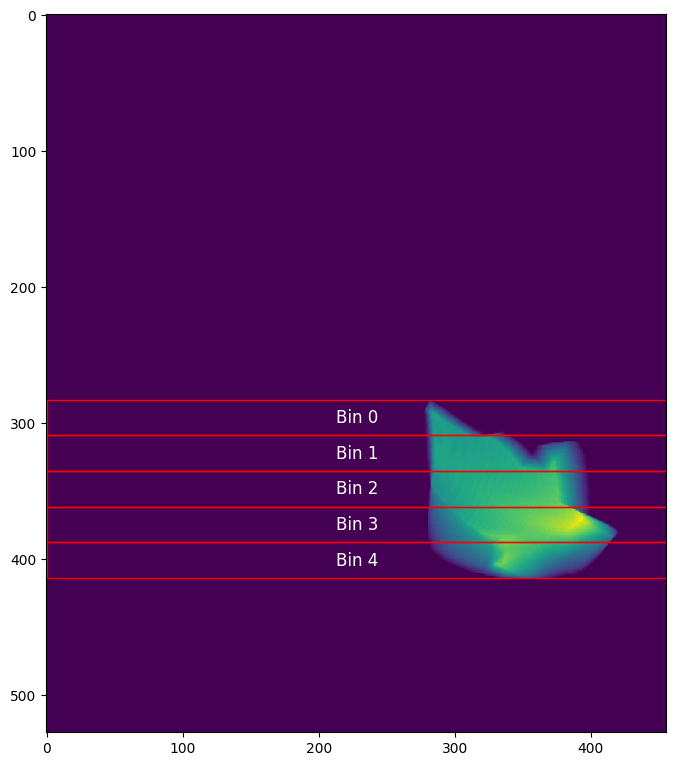

In [329]:
image_shape =np.sum(VIS_mask*contra_mask, axis=1)
fig, ax = plt.subplots(figsize=(8, 12))
ax.imshow(image_shape)

for key in bin_ranges.keys():
    y_start = AP_midpoint_VIS + bin_ranges[key][0]
    y_end = AP_midpoint_VIS + bin_ranges[key][1]
    height = y_end - y_start  # Calculate height of the bin
    rect = patches.Rectangle((0, y_start), image_shape.shape[1], height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(image_shape.shape[1] / 2, y_start + height / 2, f'Bin {key}', color='white', fontsize=12, ha='center', va='center')

# Set the limits and labels
# ax.set_xlim([0, image_shape[1]])
# ax.set_ylim([0, image_shape[0]])
# ax.set_xlabel('Width')
# ax.set_ylabel('Height')

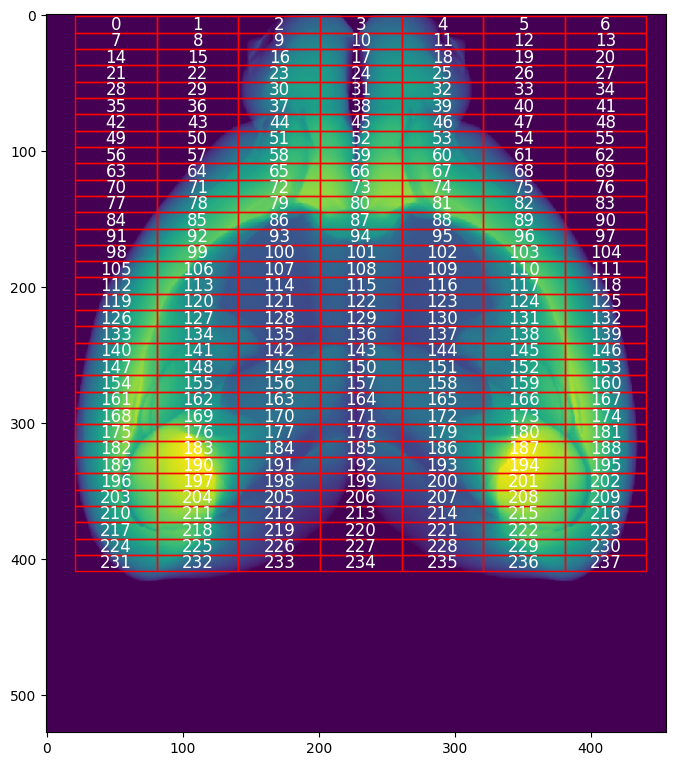

In [312]:
#now let's create AP/DV bins across the entire cortex
bin_size_micron_AP = 300
bin_size_micron_DV = 1500
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False) #688 is id for whole  cortex
indices_cortex = np.argwhere(cortex_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_cortex[:, 0])
min_y = np.min(indices_cortex[:, 0])
AP_midpoint_CORTEX = ((max_y - min_y) /2) + min_y
min_x = np.min(indices_cortex[:, 2])
max_x = np.max(indices_cortex[:, 2])
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2

#first get AP positions of centroids for every ROI in visual cortex

#then make bins to group based on certain range of AP position

#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d']
mouse_dict_positioning = {}

for mouse in mice:
    position_dict = {}
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    AP_samples = {}
    
    all_cortex_ROI = np.unique(ROI_3D * cortex_mask)
    all_cortex_ROI = [sample for sample in all_cortex_ROI if sample != 0]
    for sample in all_cortex_ROI:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        position_dict[sample] = [centroid[0], centroid[2]]
    mouse_dict_positioning[mouse]=position_dict
#now lets make equal size bins around min and max AP positions in visual cortex
bin_size_AP = bin_size_micron_AP/25#(max_y - min_y)/bin_size_max
bin_size_DV = bin_size_micron_DV/25
bin_number = int(((max_y - min_y)/bin_size_AP)*((max_x - min_x)/bin_size_DV))
bin_ranges = {}
#min_val = AP_midpoint_CORTEX - max_y
current_min_x = min_x
current_min_y = min_y
for bin in range(0, bin_number, 1):
    bin_ranges[bin] = [[current_min_y, current_min_y+bin_size_AP], [current_min_x, current_min_x+bin_size_DV]]
    if current_min_x+bin_size_DV >= max_x:
        current_min_x = min_x
        current_min_y = current_min_y+bin_size_AP
    else:
        current_min_x = current_min_x + bin_size_DV
binned_lcm_all_cortex = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    parameters = ps.load_parameters(directory=parameters_path)
    cortical_samples = parameters['cortical_samples']
    cortical_samples = [sample for sample in cortical_samples if sample in barcodes.columns]
    barcodes = barcodes[cortical_samples]
    binned_lcm_indiv_mouse={}
    position_dict = mouse_dict_positioning[mouse]
    for key in bin_ranges.keys():
        bin_list=[]
        for sample in position_dict.keys():
            if bin_ranges[key][0][0] <= position_dict[sample][0] < bin_ranges[key][0][1]:
                if bin_ranges[key][1][0] <= position_dict[sample][1] < bin_ranges[key][1][1]:
                    if sample in barcodes.columns:
                        bin_list.append(sample)
        binned_lcm_indiv_mouse[key] = bin_list
    
    binned_lcm_all_cortex[mouse] = binned_lcm_indiv_mouse
image_shape =np.sum(cortex_mask, axis=1)
fig, ax = plt.subplots(figsize=(8, 12))
ax.imshow(image_shape)

for key, value in bin_ranges.items():
    y_min, y_max = value[0]
    x_min, x_max = value[1]
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min + width / 2, y_min + height / 2, f'{key}', color='white', fontsize=12, ha='center', va='center')


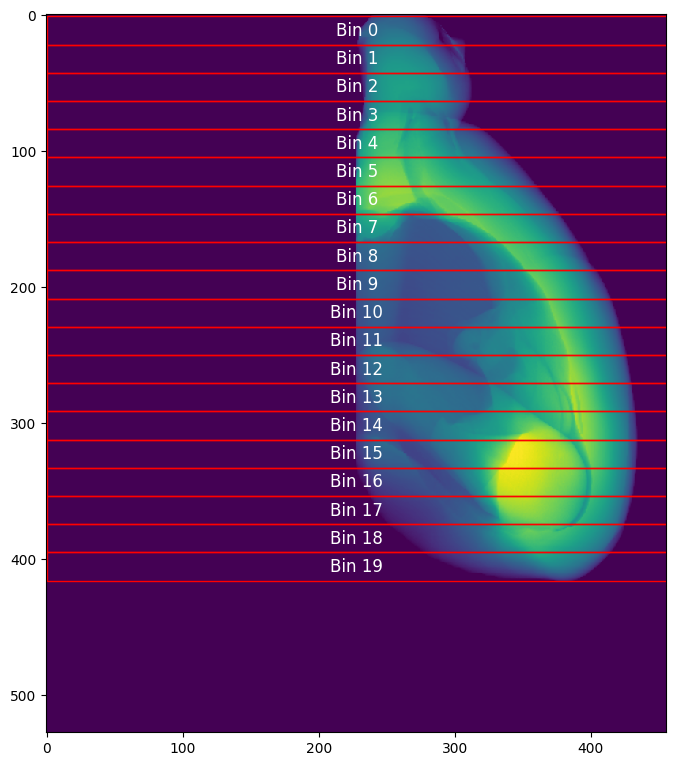

In [294]:
#first let's group centroids of ROIs in visual cortex into bins
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

bin_size_max = 20
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False) #669 is id for whole visual cortex
indices_cortex = np.argwhere(cortex_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_cortex[:, 0])
min_y = np.min(indices_cortex[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = cortex_mask.shape[2] // 2
contra_mask = np.zeros_like(cortex_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
#first get AP positions of centroids for every ROI in visual cortex

#then make bins to group based on certain range of AP position

#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d']

mouse_dict_AP_source = {}

for mouse in mice:
    AP_position_dict = {}
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    all_VIS_ROI = np.unique(ROI_3D *  cortex_mask * contra_mask)
    all_VIS_ROI = [sample for sample in all_VIS_ROI if sample != 0]
    for sample in all_VIS_ROI:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = centroid[0]-AP_midpoint_VIS
    mouse_dict_AP_source[mouse]=AP_position_dict
#now lets make equal size bins around min and max AP positions in visual cortex
bin_size = (max_y - min_y)/bin_size_max
bin_ranges = {}
min_val = AP_midpoint_VIS - max_y
for bin in range(0, int(bin_size_max), 1):
    bin_ranges[bin] = [min_val, min_val+bin_size]
    min_val = min_val+bin_size
binned_lcm = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    binned_lcm_indiv_mouse={}
    AP_position_dict = mouse_dict_AP_source[mouse]
    for key in bin_ranges.keys():
        bin_list=[]
        for AP_key in AP_position_dict.keys():
            if bin_ranges[key][0] <= AP_position_dict[AP_key] < bin_ranges[key][1]:
                if AP_key in barcodes.columns:
                    bin_list.append(AP_key)
        binned_lcm_indiv_mouse[key] = bin_list
    
    binned_lcm[mouse] = binned_lcm_indiv_mouse
    
image_shape =np.sum(cortex_mask*contra_mask, axis=1)
fig, ax = plt.subplots(figsize=(8, 12))
ax.imshow(image_shape)

for key in bin_ranges.keys():
    y_start = AP_midpoint_VIS + bin_ranges[key][0]
    y_end = AP_midpoint_VIS + bin_ranges[key][1]
    height = y_end - y_start  # Calculate height of the bin
    rect = patches.Rectangle((0, y_start), image_shape.shape[1], height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(image_shape.shape[1] / 2, y_start + height / 2, f'Bin {key}', color='white', fontsize=12, ha='center', va='center')

# Set the limits and labels
# ax.set_xlim([0, image_shape[1]])
# ax.set_ylim([0, image_shape[0]])
# ax.set_xlabel('Width')
# ax.set_ylabel('Height')

In [330]:
#create a dictionary to highlight which lcm samples are shared between AP/DV bin across cortex and the VIS AP binning
lcm_shared_dict = {}
for mouse in mice:
    for vis_bin in binned_lcm[mouse]:
        list_bin = []
        for lcm_sample in binned_lcm[mouse][vis_bin]:
            for key in binned_lcm_all_cortex[mouse]:
                if lcm_sample in binned_lcm_all_cortex[mouse][key]:
                    if key not in list_bin:
                        list_bin.append(key)
        lcm_shared_dict[vis_bin] = list_bin

In [413]:
#now look at connectivity between bins

#create a dataframe with samples put into bins
new_bc = {}
new_bc_AP = {}
for mouse in mice:
    dict_for_new_df = {}
    dict_for_AP_df = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    barcodes = barcodes.div(barcodes.sum(axis=1), axis=0)
    for bin in binned_lcm_all_cortex[mouse]:
        dict_for_new_df[bin] = barcodes[binned_lcm_all_cortex[mouse][bin]].sum(axis=1)
    new_bc[mouse] = pd.DataFrame(dict_for_new_df)
    #new_bc[mouse] = new_barcodes.div(new_barcodes.sum(axis=1), axis=0)
    for bin in binned_lcm[mouse]:
        dict_for_AP_df[bin] = barcodes[binned_lcm[mouse][bin]].sum(axis=1)
    new_barcodes_AP = pd.DataFrame(dict_for_AP_df)
    new_bc_AP[mouse] = new_barcodes_AP#new_barcodes_AP.div(new_barcodes_AP.sum(axis=1), axis=0)
combined_binned_barcodes = pd.concat([new_bc['FIAA45.6a'], new_bc['FIAA45.6d']])
#combined_binned_barcodes =combined_binned_barcodes.fillna(0) #since there may be some barcodes that don't project other cortical regions outside adjacent to soma and only project e.g. tectally
combined_binned_AP_barcodes = pd.concat([new_bc_AP['FIAA45.6a'], new_bc_AP['FIAA45.6d']])
#combined_binned_AP_barcodes =combined_binned_AP_barcodes.fillna(0)
#combined_binned_AP_barcodes = combined_binned_AP_barcodes[combined_binned_AP_barcodes.astype(bool).sum(axis=1)>0]
#combined_binned_barcodes = combined_binned_barcodes.loc[combined_binned_AP_barcodes.index]
#now let's get rid of bins that don't contain any samples
combined_binned_barcodes =combined_binned_barcodes.loc[:, (combined_binned_barcodes != 0).any(axis=0)]
#for a projection going to a visual cortex AP bin, what is the effect size co-projecting/chance of it projecting to particular DV/AP bin?

#are there any bins that have a positive/negative relationship with AP position?

In [404]:
combined_binned_barcodes =combined_binned_barcodes.loc[clustering.index]
combined_binned_AP_barcodes=combined_binned_AP_barcodes.loc[clustering.index]

In [405]:
cluster = '0'
combined_binned_barcodes =combined_binned_barcodes[clustering['leiden_0.3']==cluster]
combined_binned_AP_barcodes =combined_binned_AP_barcodes[clustering['leiden_0.3']==cluster]

In [406]:
total_neurons = len(combined_binned_AP_barcodes)
effect_df_vis_only = pd.DataFrame(data=np.zeros((len(combined_binned_AP_barcodes.columns), len(combined_binned_AP_barcodes.columns))), columns= combined_binned_AP_barcodes.columns, index=combined_binned_AP_barcodes.columns)
corr_df_vis_only = pd.DataFrame(data=np.zeros((len(combined_binned_AP_barcodes.columns), len(combined_binned_AP_barcodes.columns))), columns= combined_binned_AP_barcodes.columns, index=combined_binned_AP_barcodes.columns)
for AP_bin in combined_binned_AP_barcodes.columns:
    for cortex_bins in combined_binned_AP_barcodes.columns:
        prob_df = pd.DataFrame()
        prob_df["a"] = combined_binned_AP_barcodes[AP_bin].astype(bool)
        prob_df["b"] = combined_binned_AP_barcodes[cortex_bins].astype(bool)
        prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
        if AP_bin == cortex_bins:
            effect_df_vis_only.loc[AP_bin, cortex_bins] = np.nan
            corr_df_vis_only.loc[AP_bin, cortex_bins] = np.nan
        else:
            effect_df_vis_only.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*total_neurons))
            corr_df_vis_only.loc[AP_bin, cortex_bins] = combined_binned_AP_barcodes[AP_bin].corr(combined_binned_AP_barcodes[cortex_bins], method='spearman')

corr = np.log2(effect_df_vis_only)
corr.replace([np.inf, -np.inf], np.nan, inplace=True)
effect_df_new = effect_df_vis_only.reset_index()
correlation_df =effect_df_new.corr(method='spearman')['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])


correlations = []
p_value_df = {}
for column in effect_df_vis_only.columns:
    col_to_comp = effect_df_new[[column, 'index']].dropna()
    if len (col_to_comp) >0:
        correlation, p_value = pearsonr(col_to_comp[column], col_to_comp['index'])
        p_value_df[column] = p_value
p_val_filtered = pd.DataFrame(p_value_df, index=[0])*len(p_value_df)
columns = [column for column in p_val_filtered if p_val_filtered[column][0]<=0.05]
p_val_filtered[columns]

""
0


In [416]:
combined_binned_AP_barcodes

,0,1,2,3,4
sequence,,,,,
GAGCGTGAGGCAGGTTTCGTATGGGGCGCTTC,0.003416,0.008639,0.082253,0.065645,0.018890
GAACGCTTAGGGGGAACTACGTTCTTGTGGTC,0.128516,0.018377,0.000000,0.401830,0.051162
GGAATTTCGTTCGCTCTCGGTAGGTGGCATTT,0.000000,0.000000,0.000000,0.124979,0.000000
TGTTGTGCGTTGGTGGGGCATGAAGGGTTCCC,0.092119,0.000000,0.000000,0.096320,0.070301
TAATGTATTATCGTTTGGCACAGGTACCAGTT,0.000000,0.000000,0.000000,0.254076,0.000000
...,...,...,...,...,...
TTTCTACAGACCGTCAAGAACACCGAAGCCTC,0.000000,0.000000,0.000000,0.000000,0.000000
GGTATTGGATGTGTTACCCCCTCCGCCTCGCT,0.000000,0.000000,0.000000,0.000000,0.000000
AGTTGCGGGATGACGGAAGGAGGAGGGATCTT,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
cluster_dict = []
for cluster in str(np.arange(0, 1, 9)):
    cluster_look = combined_binned_AP_barcodes.copy()
    cluster_look =cluster_look.loc[clustering.index]
    cluster_look=cluster_look.loc[clustering.index]
    cluster_look =cluster_look[clustering['leiden_0.3']==cluster]
    cluster_dict[cluster] = combined_binned_AP_barcodes.sum(axis=0)/len(cluster_look)

/tmp/ipykernel_2868268/2859376232.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_binned_AP_barcodes =combined_binned_AP_barcodes[clustering['leiden_0.3']==cluster]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

Text(0.5, 1.0, 'Pearson correlations between HVA AP bins')

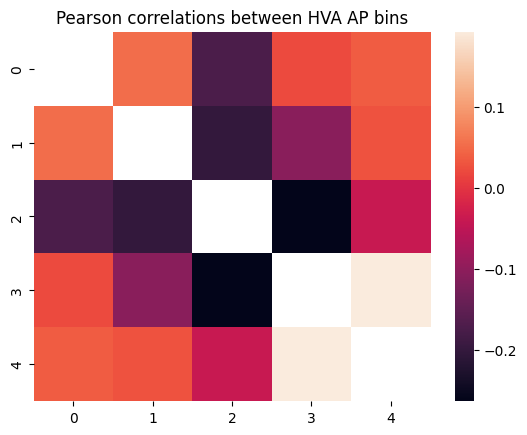

In [407]:
sb.heatmap(corr_df_vis_only)
plt.title('Pearson correlations between HVA AP bins')

Text(0.5, 1.0, 'Over/underrepresented co-projection motifs between HVA AP bins')

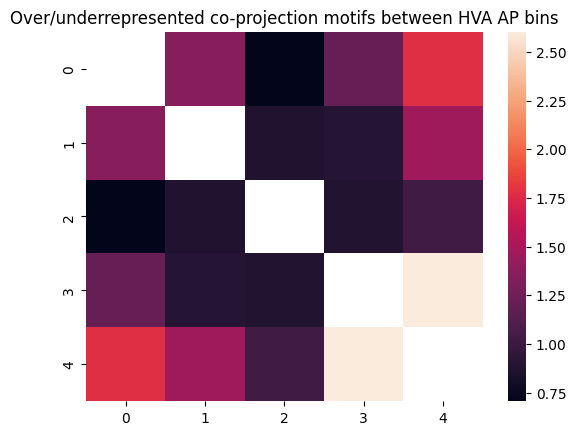

In [408]:
sb.heatmap(effect_df_vis_only) 
plt.title('Over/underrepresented co-projection motifs between HVA AP bins')

In [372]:

corr_df_vis_only_new = corr_df_vis_only.reset_index()
correlation_df =corr_df_vis_only_new.corr(method='spearman')['index']
correlation_df =pd.DataFrame(corr_df_vis_only_new).T
correlation_df = corr_df_vis_only_new.drop(columns=['index'])

correlations = []
p_value_df = {}
for column in correlation_df.columns:
    col_to_comp = corr_df_vis_only_new[[column, 'index']].dropna()
    if len (col_to_comp) >0:
        correlation, p_value = pearsonr(col_to_comp[column], col_to_comp['index'])
        p_value_df[column] = p_value
p_val_filtered = pd.DataFrame(p_value_df, index=[0])*len(p_value_df)
columns = [column for column in p_val_filtered if p_val_filtered[column][0]<=0.05]
p_val_filtered[columns]

,1
0,0.042943


<AxesSubplot:>

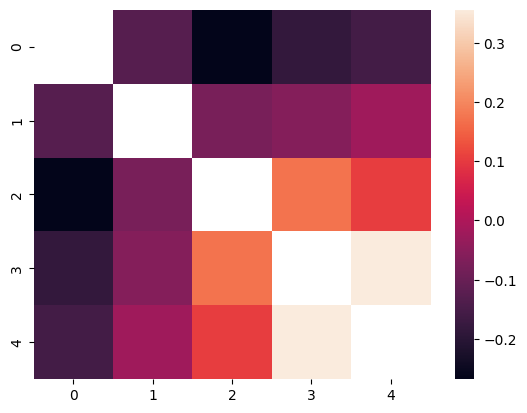

In [217]:
sb.heatmap(corr_df_vis_only) 

<AxesSubplot:>

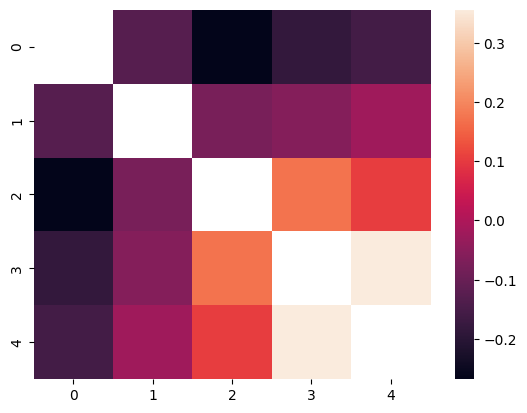

In [208]:
sb.heatmap(corr_df_vis_only)

In [340]:
for AP_bin in combined_binned_AP_barcodes.columns:
    for cortex_bins in combined_binned_AP_barcodes.columns:
        prob_df = pd.DataFrame()
        prob_df["a"] = combined_binned_AP_barcodes[AP_bin].astype(bool)
        prob_df["b"] = combined_binned_AP_barcodes[cortex_bins].astype(bool)
        prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
        if AP_bin == combined_binned_AP_barcodes:
            effect_df_vis_only.loc[AP_bin, cortex_bins] = np.nan
            corr_df_vis_only.loc[AP_bin, cortex_bins] = np.nan
        else:
            effect_df_vis_only.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*total_neurons))
            corr_df_vis_only = combined_binned_AP_barcodes[AP_bin].corr(combined_binned_AP_barcodes[cortex_bins], method='spearman')


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [341]:
total_neurons = len(combined_binned_barcodes)
effect_df = pd.DataFrame(data=np.zeros((len(combined_binned_AP_barcodes.columns), len(combined_binned_barcodes.columns))), columns= combined_binned_barcodes.columns, index=combined_binned_AP_barcodes.columns)
corr_df = pd.DataFrame(data=np.zeros((len(combined_binned_AP_barcodes.columns), len(combined_binned_barcodes.columns))), columns= combined_binned_barcodes.columns, index=combined_binned_AP_barcodes.columns)
for AP_bin in combined_binned_AP_barcodes.columns:
    for cortex_bins in combined_binned_barcodes.columns:
        prob_df = pd.DataFrame()
        prob_df["a"] = combined_binned_AP_barcodes[AP_bin].astype(bool)
        prob_df["b"] = combined_binned_barcodes[cortex_bins].astype(bool)
        prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
        if cortex_bins in lcm_shared_dict[AP_bin]:
            effect_df.loc[AP_bin, cortex_bins] = np.nan
        else:
            effect_df.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*total_neurons))
corr = np.log2(effect_df)
corr.replace([np.inf, -np.inf], np.nan, inplace=True)
effect_df_new = effect_df.reset_index()
correlation_df =effect_df_new.corr()['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])
correlation_df =effect_df_new.corr()['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])
from scipy.stats import pearsonr
correlations = []
p_value_df = {}
for column in correlation_df.columns:
    col_to_comp = effect_df_new[[column, 'index']].dropna()
    if len (col_to_comp) >0:
        correlation, p_value = pearsonr(col_to_comp[column], col_to_comp['index'])
        p_value_df[column] = p_value
p_val_filtered = pd.DataFrame(p_value_df, index=[0])*len(p_value_df)
columns = [column for column in p_val_filtered if p_val_filtered[column][0]<=0.05]
p_val_filtered[columns]

/tmp/ipykernel_2868268/538679621.py:13: RuntimeWarning: invalid value encountered in double_scalars
  effect_df.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*total_neurons))
/tmp/ipykernel_2868268/538679621.py:13: RuntimeWarning: invalid value encountered in double_scalars
  effect_df.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*total_neurons))
/tmp/ipykernel_2868268/538679621.py:13: RuntimeWarning: invalid value encountered in double_scalars
  effect_df.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*total_neurons))
/tmp/ipykernel_2868268/538679621.py:13: RuntimeWarning: invalid value encountered in double_scalars
  effect_df.loc[AP_bin, cortex_bins] = prob_df["matching"].sum()/(((prob_df["a"].sum()/total_neurons)*(prob_df["b"].sum()/total_neurons)*tota

""
0


In [342]:
corr = np.log2(effect_df)
corr.replace([np.inf, -np.inf], np.nan, inplace=True)


/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


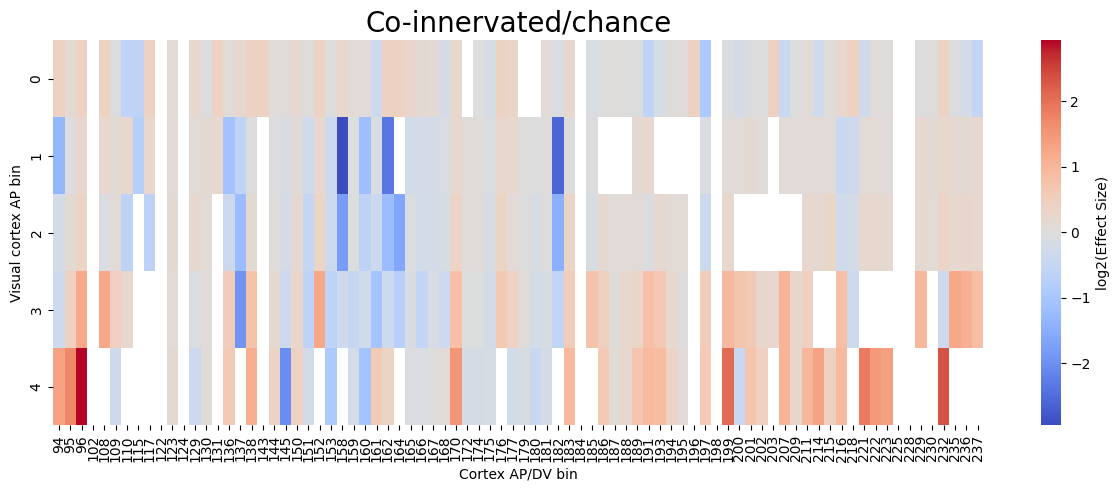

In [343]:
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the size as needed (width, height)

# Plot the heatmap
sb.heatmap(data=corr, cmap='coolwarm', xticklabels=True, center=0, cbar_kws={'label': 'log2(Effect Size)'}, ax=ax)

# Show the plot
ax.set_xlabel('Cortex AP/DV bin')  
ax.set_ylabel('Visual cortex AP bin') 
plt.title('Co-innervated/chance', size=20) 
plt.show()

<AxesSubplot:>

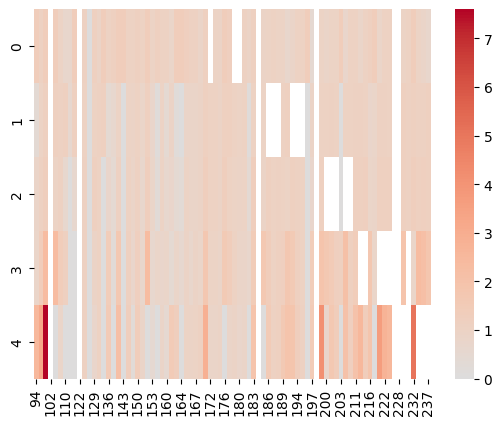

In [344]:
sb.heatmap(data = effect_df, cmap='coolwarm', center=0)

In [345]:
effect_df_new = effect_df.reset_index()
correlation_df =effect_df_new.corr()['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])
correlation_df =effect_df_new.corr()['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])
from scipy.stats import pearsonr
correlations = []
p_value_df = {}
for column in correlation_df.columns:
    col_to_comp = effect_df_new[[column, 'index']].dropna()
    if len (col_to_comp) >0:
        correlation, p_value = pearsonr(col_to_comp[column], col_to_comp['index'])
        p_value_df[column] = p_value

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [346]:
p_val_filtered = pd.DataFrame(p_value_df, index=[0])*len(p_value_df)
columns = [column for column in p_val_filtered if p_val_filtered[column][0]<=0.05]
p_val_filtered[columns]


""
0


In [347]:
total_neurons = len(combined_binned_barcodes)
corr_df = pd.DataFrame(data=np.zeros((len(combined_binned_AP_barcodes.columns), len(combined_binned_barcodes.columns))), columns= combined_binned_barcodes.columns, index=combined_binned_AP_barcodes.columns)
for AP_bin in combined_binned_AP_barcodes.columns:
    for cortex_bins in combined_binned_barcodes.columns:
        correlation = combined_binned_AP_barcodes[AP_bin].corr(combined_binned_barcodes[cortex_bins], method='spearman')
        if cortex_bins in lcm_shared_dict[AP_bin]:
            corr_df.loc[AP_bin, cortex_bins] = np.nan
        else:
            corr_df.loc[AP_bin, cortex_bins] = correlation


/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


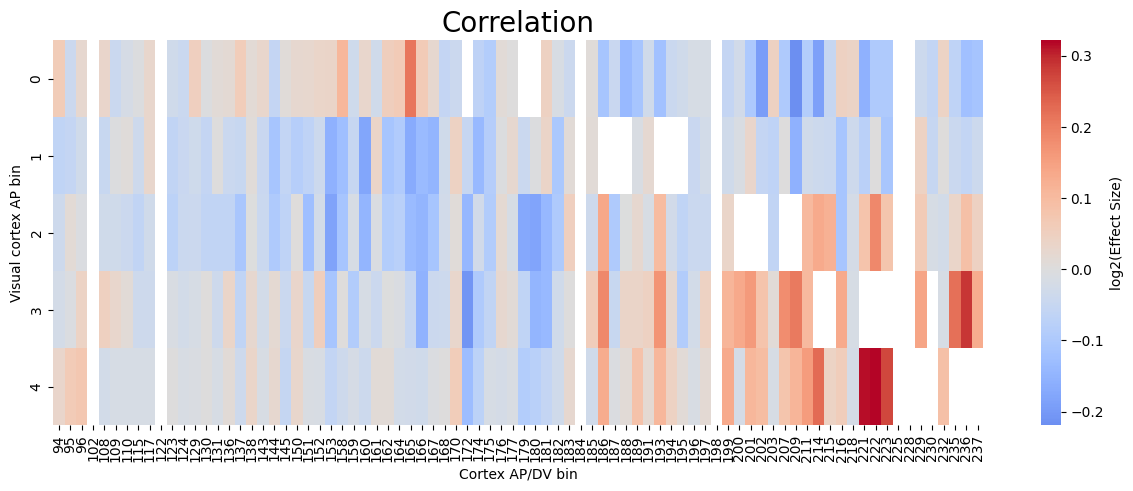

In [352]:
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the size as needed (width, height)

# Plot the heatmap
sb.heatmap(data=corr_df, cmap='coolwarm', xticklabels=True, center=0, cbar_kws={'label': 'log2(Effect Size)'}, ax=ax)

# Show the plot
ax.set_xlabel('Cortex AP/DV bin')  
ax.set_ylabel('Visual cortex AP bin') 
plt.title('Correlation', size=20) 
plt.show()

<AxesSubplot:>

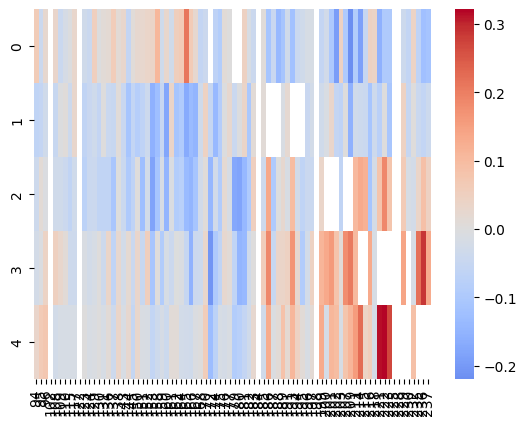

In [348]:
sb.heatmap(data=corr_df, cmap='coolwarm', center =0, xticklabels=True)

In [349]:
corr_df_new = corr_df.reset_index()
correlation_df =effect_df_new.corr()['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])
correlation_df =effect_df_new.corr()['index']
correlation_df =pd.DataFrame(correlation_df).T
correlation_df = correlation_df.drop(columns=['index'])
from scipy.stats import pearsonr
correlations = []
p_value_df = {}
for column in correlation_df.columns:
    col_to_comp = effect_df_new[[column, 'index']].dropna()
    if len(col_to_comp)>0:
        correlation, p_value = pearsonr(col_to_comp[column], col_to_comp['index'])
        p_value_df[column] = p_value

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [350]:
p_val_filtered = pd.DataFrame(p_value_df, index=[0])*len(p_value_df)
columns = [column for column in p_val_filtered if p_val_filtered[column][0]<=0.05]
p_val_filtered[columns]

""
0


In [351]:
p_val_filtered

,94,95,96,108,109,110,115,117,123,124,...,218,221,222,223,229,230,232,235,236,237
0,26.194314,10.064243,8.521722,50.387099,70.421151,36.288885,3.716816,0.631274,34.109705,NaN,...,3.871048,5.638699,6.68947,7.344082,11.195499,35.604764,18.86564,11.702037,7.580765,4.646753


In [174]:
for bin in binned_lcm_all_cortex[mouse]:
        dict_for_new_df[bin] = barcodes[binned_lcm_all_cortex[mouse][bin]].sum(axis=1)
new_barcodes = pd.DataFrame(dict_for_new_df)
new_bc[mouse] = new_barcodes.div(new_barcodes.sum(axis=1), axis=0)

In [179]:
new_barcodes.loc['TATGGGAGCACGCGAGATTCCAGATTTATGCT'].sum()

0.0

In [164]:
new_bc['FIAA45.6d'].loc['TATGGGAGCACGCGAGATTCCAGATTTATGCT']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
162   NaN
163   NaN
164   NaN
165   NaN
166   NaN
Name: TATGGGAGCACGCGAGATTCCAGATTTATGCT, Length: 167, dtype: float64

In [149]:
df =combined_binned_barcodes.loc[:, (combined_binned_barcodes != 0).any(axis=0)]

In [183]:
combined_binned_barcodes.loc[:, (combined_binned_barcodes != 0).any(axis=0)]

,21,58,71,72,73,74,84,85,86,87,...,152,153,154,155,157,158,163,164,165,166
sequence,,,,,,,,,,,,,,,,,,,,,
GAGCGTGAGGCAGGTTTCGTATGGGGCGCTTC,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.051319,0.027975,0.0,0.011713,0.0,0.0,0.013118,0.001934
GAACGCTTAGGGGGAACTACGTTCTTGTGGTC,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.258506,0.143744,0.0,0.019949,0.0,0.0,0.000000,0.015353
GGAATTTCGTTCGCTCTCGGTAGGTGGCATTT,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.124979,0.0,0.000000,0.0,0.0,0.000000,0.000000
TGTTGTGCGTTGGTGGGGCATGAAGGGTTCCC,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.303904,0.0,0.000000,0.0,0.0,0.000000,0.000000
TAATGTATTATCGTTTGGCACAGGTACCAGTT,0.0,0.0,0.0,0.013755,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.179501,0.074575,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCATATGGTAGCGGTTTGAGAGGTTCGGGCCT,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
TAACTGGTTATCAGTATTATCCAAGTGCCGTC,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
TGGCTTATTACTGTAAATCCGCTGGAATAATT,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [189]:
rows_with_nan = combined_binned_barcodes[combined_binned_barcodes.isna().any(axis=1)]

In [190]:
rows_with_nan

,21,58,71,72,73,74,84,85,86,87,...,152,153,154,155,157,158,163,164,165,166
sequence,,,,,,,,,,,,,,,,,,,,,


In [156]:
barcodes.loc['TATGGGAGCACGCGAGATTCCAGATTTATGCT']

1       0.000000
2      31.479307
3       0.000000
4       0.000000
5       0.000000
         ...    
186     0.000000
187     0.000000
188     0.000000
189     0.000000
190     0.000000
Name: TATGGGAGCACGCGAGATTCCAGATTTATGCT, Length: 168, dtype: float64

In [73]:
max_y = np.max(indices_cortex[:, 0])
min_y = np.min(indices_cortex[:, 0])
AP_midpoint_CORTEX = ((max_y - min_y) /2) + min_y
min_x = np.min(indices_cortex[:, 2])
max_x = np.max(indices_cortex[:, 2])

In [57]:
 mouse_dict_positioning['FIAA45.6a']

{3.0: [412.0554640307523, 342.6263042284459],
 4.0: [411.42657713376923, 362.4594451316487],
 5.0: [414.3693824946767, 82.74683402443125],
 8.0: [404.27204428627914, 311.8098062475287],
 9.0: [404.1469165659008, 331.21644498186214],
 11.0: [405.07379921665637, 371.5122655122655],
 12.0: [404.5902241822859, 309.8019110621095],
 14.0: [406.6595077957811, 105.24079027820238],
 15.0: [394.5749494949495, 291.1636363636364],
 16.0: [393.9759522272434, 309.30761781794706],
 17.0: [392.2796257796258, 329.88383575883574],
 18.0: [391.5658747300216, 350.7955723542117],
 19.0: [390.14951005152034, 367.37690675825843],
 20.0: [388.6941553242594, 383.06575260208166],
 21.0: [385.6645717626425, 394.27345805320084],
 22.0: [384.0740922473013, 407.98462544978736],
 23.0: [393.3679153621937, 297.0213753643528],
 27.0: [395.17433976400076, 92.52150215396142],
 28.0: [379.90523518992325, 297.7934461720134],
 29.0: [379.098930208864, 322.40458481915437],
 30.0: [377.85589626488337, 346.3710650791062],
 31

In [ ]:
#now 